In [ ]:
IRdisplay::display_html(file='code_hiding.html')

In [ ]:
#install.packages("gridExtra")

In [ ]:
#find.package("gridExtra")

In [1]:
# load packages and define constants
library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
library(gridExtra)      # to use grid.arrange()
source("R_functions.r") # custom functions

# folder/file-specific constants
PILOT_NUMBER <- 'test'
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# key-specific constants 
TRIALS <- "trials"
FRAMES <- "frames"
DOTS <- "dots"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [2]:
if (is.numeric(PILOT_NUMBER)) {
    # load csv files into data.tables
    tb <- list(
        loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG),
        loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG),
        loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG))
    names(tb) <- c(TRIALS, FRAMES, DOTS)
} else if (is.character(PILOT_NUMBER)) {
    # load csv files into data.tables
    tb <- list(
        loadTestCSV(DATA_FOLDER, FIRA_TAG),
        loadTestCSV(DATA_FOLDER, FRAMES_TAG),
        loadTestCSV(DATA_FOLDER, DOTS_TAG))
    names(tb) <- c(TRIALS, FRAMES, DOTS)
}

# add a trialCount column to the TRIALS and FRAMES table
tb[[TRIALS]][,trialCount:=.I]
# tb[[FRAMES]] <- tb[[FRAMES]][tb[[TRIALS]][,.(trialCount, trialIndex)],on="trialIndex"]

# add all the fields from the TRIALS table to the DOTS table for Reverse Kernel analysis
# tb[[DOTS]] <- tb[[DOTS]][tb[[TRIALS]],on="trialCount"]

**Author**: Adrian Ernesto Radillo
**Date**: 15 Feb 2019

# Introduction
## Notebook's goals

Analyze data collected on myself. Two subgoals:
1. make sure the task and stimulus behave as we want, to the smallest detail
2. start building up an analysis pipeline for the actual study

## A word on the data for this notebook
The tag for this data is `test`. It was collected in the office.<!-- with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot10.mat).-->

I timed with my phone the elapsed time between launching the task via the GUI and the time of closing the GUI.
This roughly amounted to 22 minutes.

## Feedback about my own impressions doing the task
- luminance on booth's screen is too high (almost hurts my eyes)
- 20 minutes of the task seems reasonable without any breaks. I would not ask subjects to do longer durations without breaks.
- getting comfy is ultre important
- and doing several trials (at least 40) in presence of the experimenter to give him oral, real-time feedback, is really important too.
- a displeased subject, for any reason, is a no-go
- hence I should have a way for the subject to trigger a pause when he/she needs it. Josh told me that breaking fixation does that automatically. I need to test it.


## Data analysis workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot#.mat` and upload it to PennBox (location = Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- There is a clear problem in the way my code defines change points. This needs to be fixed.
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- With 345 trials, dotsPositions.csv file is already around 50 MB big with 1.2 million rows! This is too much.
    - I could remove a lot of the 'dumping'
    - I could try to adopt the [NWB](https://www.nwb.org/) data format.

## Unordered questions to address in this notebook
1. How many frames are skipped on each trial, and where in the trial do they occur?
    - Does this number match the offset in viewing duration per trial?
1. Compute reverse kernels with the number of coherent dots as a proxy for motion energy
1. Plot indep var. as fcn of trial count, to ensure real randomization was implemented by the task algorithm.


# Exploring the data
## The `*FIRA.csv` file (trials level)

In [3]:
str(tb[[TRIALS]])

Classes ‘data.table’ and 'data.frame':	12 obs. of  28 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  7 1 11 2 10 12 9 6 8 4 ...
 $ trialStart     : num  30379 30384 30387 30391 30395 ...
 $ trialEnd       : num  30384 30387 30391 30395 30398 ...
 $ RT             : num  0.411 0.575 0.585 0.731 0.765 ...
 $ choice         : int  0 0 0 1 1 0 0 0 1 0 ...
 $ correct        : int  1 0 1 1 1 1 1 1 1 0 ...
 $ initDirection  : int  0 0 0 180 180 180 0 180 180 180 ...
 $ endDirection   : int  180 0 180 0 0 180 180 180 0 0 ...
 $ presenceCP     : int  1 0 1 1 1 0 1 0 1 1 ...
 $ coherence      : num  60 25.6 60 25.6 25.6 60 25.6 25.6 60 60 ...
 $ viewingDuration: num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ probCP         : num  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  6194 3479 6952 8772 5634 5058 4168 7043 6004 2247 ...
 $ fixationOn     : num  0.887 0.28

## The `*framesInfo.csv` file (frames level)

In [4]:
str(tb[[FRAMES]])

Classes ‘data.table’ and 'data.frame':	413 obs. of  6 variables:
 $ frameTotCount: int  597 598 599 600 601 602 603 604 605 606 ...
 $ onsetTime    : num  30380 30382 30382 30382 30382 ...
 $ onsetFrame   : int  885 964 967 972 973 974 975 976 977 978 ...
 $ swapTime     : num  30380 30382 30382 30382 30382 ...
 $ isTight      : int  0 0 0 0 1 1 1 1 1 1 ...
 $ trialIndex   : int  7 7 7 7 7 7 7 7 7 7 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## The `*dotsPositions.csv` file (dots level)

In [5]:
str(tb[[DOTS]])
#tb[[DOTS]][,.(.N),by=.(frameIdx,trialCount)]

Classes ‘data.table’ and 'data.frame':	66248 obs. of  6 variables:
 $ xpos      : num  0.3826 0.0383 0.1578 0.5403 0.9563 ...
 $ ypos      : num  0.3775 0.2884 0.0793 0.7164 0.7768 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent: int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
cat("number of active dots per frame appearing across trials",
    unique(tb[[DOTS]][,.(numDots=sum(isActive)), by=.(trialCount,frameIdx)][,numDots])
    ,"\n")

number of active dots per frame appearing across trials 61 60 


# Timing and trial checks
How long did the session last?

In [7]:
cat( round(tb[[TRIALS]][,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

0.75 min

How many trials were produced?

In [8]:
nrow(tb[[TRIALS]])

[1] 12

Did any trial fail?

In [9]:
cat('there are',nrow(tb[[TRIALS]][is.na(choice)]),'trials where choice = NA:')
tb[[TRIALS]][is.na(choice),.(trialIndex, trialCount)]

there are 0 trials where choice = NA:

trialIndex,trialCount


Were some trials presented again after failure?

In [10]:
cat('trialIndex:',tb[[TRIALS]][,trialIndex][duplicated(tb[[TRIALS]][,.(trialIndex)])])

trialIndex: 

In [12]:
# tb[[TRIALS]][trialIndex == 1 | trialIndex == 2 | trialIndex == 5][order(trialIndex)]

**We get rid of failed trials.**

In [13]:
tb[[TRIALS]] <- tb[[TRIALS]][!is.na(choice)]
numTrials <- nrow(tb[[TRIALS]])

- How many trials were produced per combination of factors?

In [14]:
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(tb[[TRIALS]], indepVarNames)
combFactors

initDirection,presenceCP,coherence,viewingDuration,probCP,timeCP,freq.
0,1,60.0,0.5,0.6,0.2,2
0,0,25.6,0.5,0.6,0.2,1
180,1,25.6,0.5,0.6,0.2,2
180,0,60.0,0.5,0.6,0.2,1
0,1,25.6,0.5,0.6,0.2,2
180,0,25.6,0.5,0.6,0.2,1
180,1,60.0,0.5,0.6,0.2,2
0,0,60.0,0.5,0.6,0.2,1


- What were the marginal frequencies?

In [15]:
for (i in 1:length(indepVarNames)) {
  print(getFreq(tb[[TRIALS]], indepVarNames[i]))
}

   initDirection freq.
1:             0     6
2:           180     6
   presenceCP freq.
1:          1     8
2:          0     4
   coherence freq.
1:      60.0     6
2:      25.6     6
   viewingDuration freq.
1:             0.5    12
   probCP freq.
1:    0.6    12
   timeCP freq.
1:    0.2    12


We now plot the independent variables as a function of trial number in the task, to check randomization (at least eye-balling).

In [ ]:
# longTRIALS <- melt(tb[[TRIALS]][,viewingDuration := dotsOff - dotsOn], id.vars="trialCount", 
#                   measure.vars=c("viewingDuration",
#                                 "coherence",
#                                 "initDirection",
#                                 "endDirection",
#                                 "presenceCP"),
#                   variable.name="IndepVar")

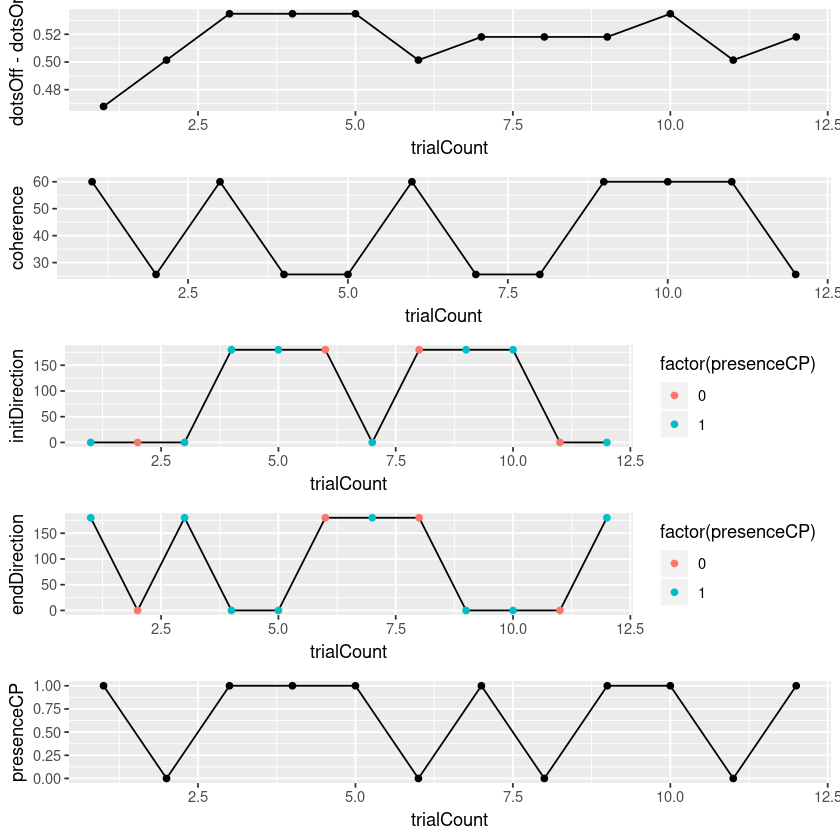

In [17]:
p1 <- ggplot(tb[[TRIALS]], aes(x=trialCount, y=dotsOff - dotsOn)) + geom_line()  + geom_point()
p2 <- ggplot(tb[[TRIALS]], aes(x=trialCount, y=coherence)) + geom_line() + geom_point()
p3 <- ggplot(tb[[TRIALS]], aes(x=trialCount, y=initDirection)) + geom_line()  + geom_point(aes(col=factor(presenceCP)))
p4 <- ggplot(tb[[TRIALS]], aes(x=trialCount, y=endDirection))  + geom_line() + geom_point(aes(col=factor(presenceCP)))
p5 <- ggplot(tb[[TRIALS]], aes(x=trialCount, y=presenceCP)) + geom_line()  + geom_point()
grid.arrange(p1,p2,p3,p4,p5, nrow=5) 

Clearly there is a problem with my definition of change points :(

## A deeper look at the timestamps fields

In [ ]:
# for this particular dataset, the timestamps of most columns have the wrong offset. This bug has been fixed since.
# for now, we still need to manually correct the time values as follows:
wideTimestamps <- tb[[TRIALS]][,.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  trialCount,
                                  presenceCP),by=trialIndex]

In [ ]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
# str(longTimestamps)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=8)
# plot
ggplot(longTimestamps, aes(x=trialCount, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- How precise were the dots timings?  

We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

In [ ]:
durTable <- tb[[TRIALS]][,.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=trialCount]
# str(durTable)
# call to ggplot()
g <- ggplot(durTable, aes(x=trialCount, y=dotsDurationError)) + 
  geom_line(size=.2) +  
  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) +
  geom_hline(yintercept = FRAME_DURATION*1000, linetype="dashed") +
  annotate("text", x=37, y=FRAME_DURATION*1000, vjust = 1.3, label = c("1 frame"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="duration error (msec)", 
         x="trial (in session order)",
         color="viewing dur.", shape="CP") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

Below I try to estimate the mean errors, clustered. 

In [ ]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` calls.

In [ ]:
longDotsOffTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialIndex","presenceCP"),
                       measure.vars=c("nTocDotsOn","nDotsOn","nTocDotsOff","nDotsOff"),
                       value.name="timestamp", variable.name="Event")

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longDotsOffTimestamps, aes(x=trialIndex, y=timestamp)) + 
   geom_point(aes(col=Event, shape=factor(presenceCP)), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
        shape="Change Point") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Checking that the three datasets are consistent
As we can see, the `frameIdx` field is common to `tb[[FRAMES]]` and `tb[[DOTS]]`, and the `trialIdx` is common to `tb[[DOTS]]` and `tb[[TRIALS]]`. Let's check whether these common fields match in terms of their unique values in each dataset.

## Exploring match between `DOTS` and `TRIALS` levels

## Exploring match between `FRAMES` and `TRIALS` levels
### Timing of trial vs. timing of frames

In [ ]:
# add (bug-corrected) dotsOn, dotsOff values to filter swapTimes
# add trialStart for future offset
# the syntax is that of a right join
frameTimes <- tb[[FRAMES]][tb[[TRIALS]][,.(trialStart, 
                                           dotsOn, 
                                           dotsOff, 
                                           trialIndex)], on="trialIndex"]

# only consider frames with onsetTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]
# str(frameTimes)

- does the "number of frames" match across the three files?

In [ ]:
setkey(frameTimes, trialIndex)
setkey(tb[[TRIALS]], trialIndex)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    tb[[TRIALS]][,.(numInTRIALS=numFrames, trialCount),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

# str(frameCount)

In [ ]:
frameCount <- frameCount[tb[[DOTS]][order(trialIndex),.(numInDOTS=max(frameIdx)),by=trialIndex],on="trialIndex"]
frameCount[,.(trialIndex, trialCount, numInTRIALS,numInFRAMES,numInDOTS,match=numInFRAMES == numInDOTS)]

From the columns above, we see that:
- the `numFrames` field from the `tb[[TRIALS]]` table is not useful
- I should match dots and frames using timestamps

- what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [ ]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
                                   lastFrame=max(onsetTime-trialStart)-dotsOn,
                                   trialStart, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn,
                                   trialCount),
                                  by=trialIndex]
# str(extremeFrameTimes)

In [ ]:
1.3# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)


frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
   geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
   annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- Exploration of `Tight` frames in each trial

In [ ]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=onsetTime-(dotsOn+trialStart))) + 
   geom_point(aes(col=factor(isTight)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
   theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## Exploring match between `FRAMES` and `DOTS`

In [ ]:
# unique(tb[[DOTS]][,frameIdx])
# tb[[DOTS]][order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

# Accuracy analysis
- Accuracy (% correct) on the task

In [ ]:
accuracy <- sum(tb[[TRIALS]][,correct])/numTrials
cat(accuracy * 100,"%", sep = '')

- Accuracy on CP vs. non-CP trials

In [ ]:
# count CP and Non-CP trials
cpGrouping <- getFreq(tb[[TRIALS]], "presenceCP")
numCPtrials <- cpGrouping[presenceCP == 1, freq.]
numNonCPtrials <- cpGrouping[presenceCP == 0, freq.]

# compute accuracies in each group of trials
accuracy_CP <- sum(tb[[TRIALS]][presenceCP == 1, correct])/numCPtrials * 100
accuracy_nonCP <- sum(tb[[TRIALS]][presenceCP == 0, correct])/numNonCPtrials * 100
# round to 2 decimals
accuracy_CP <- round(accuracy_CP, digits = 2)
accuracy_nonCP <- round(accuracy_nonCP, digits = 2)

# display summarizing table
toDisplay <- cpGrouping[, ("accuracy") := data.frame("accuracy"=c(accuracy_nonCP, accuracy_CP))]
print(toDisplay)
# toDisplay # print a second time because of a bug that I don't fully understand (see https://github.com/IRkernel/IRkernel/issues/127 and https://github.com/rstudio/rmarkdown/issues/1002)

- Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(viewingDuration),.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

- Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(coherence),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
toDisplay <- toDisplay[,.(coherence, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

- Group by change point presence after CP time

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][viewingDuration > .2,
                  .(freq = .N, correct = sum(correct)), 
                  by=.(viewingDuration, presenceCP)]
# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, presenceCP,  accuracy = round(correct/freq*100,digits=2))]
toDisplay

# Reverse Kernel Analysis

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [ ]:
# count coherent dots on each frame
cohDots <- tb[[DOTS]][,
                      .(numCohDots=sum(isCoherent), 
                        initDirection, 
                        endDirection, 
                        presenceCP),
                      by=.(frameIdx, trialCount)]

# see if some frames have 0 coherent dots
unique(cohDots[numCohDots == 0,.(trialCount,frameIdx)])

In [ ]:
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)
## add a copy of numCohDots column named signedNumCohDots, and an ID col that just indexes the rows
cohDots[,"signedNumCohDots" := .(numCohDots)]

In [ ]:
## on non-cp trials, adjust sign according to initDirection
cohDots[initDirection == 180 & presenceCP == 0, signedNumCohDots := -numCohDots] 

In [ ]:
## on cp-trials,
    # rough estimate of number of frames that are before the CP (for now)
if (length(unique(tb[[TRIALS]]$timeCP)) == 1) {
    foreFrameCount <- tb[[TRIALS]][,timeCP][1] * FRAME_RATE_ESTIMATE
} 

In [ ]:
foreFrameCount

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==180 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx <= foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx <= foreFrameCount,rowNumber]]

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==0 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx > foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx > foreFrameCount,rowNumber]]

In [ ]:
# diagnostic
unique(cohDots[presenceCP == 1,
               .(initDirection,endDirection,presenceCP,numCohDots,signedNumCohDots) ,
               by=.(frameIdx,trialCount)])

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=60)

# add ID col to tb[[DOTS]] and cohDots to perform a join
tb[[DOTS]][,ID:=.I]
cohDots[,rowNumber := NULL]
cohDots[,ID:=.I]

# plot
ggplot(tb[[DOTS]][cohDots, on=c("ID","frameIdx","trialCount")], aes(x=frameIdx, y=signedNumCohDots)) + 
    geom_point(aes(col=factor(correct), shape=factor(presenceCP)), size=2) +
    facet_grid(trialIndex~coherence) +
#    geom_line(aes(col=Event),size=.2) +
    geom_hline(yintercept = 0) +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="Signed # of Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- tb[[TRIALS]][,.(randSeedBase,trialIndex),by=trialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=trialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text